In [1]:
import cv2
import copy
import numpy as np
import torch
import torchvision
import PIL.Image
from IPython.display import display, Image
from jetcam.utils import bgr8_to_jpeg
from jetcam.csi_camera import CSICamera
from cnn.center_dataset import TEST_TRANSFORMS

# 카메라 설정
camera = CSICamera(capture_device=0, capture_width=1280, capture_height=720, downsample=2, capture_fps=30)


Error generated. /dvs/git/dirty/git-master_linux/multimedia/nvgstreamer/gst-nvarguscamera/gstnvarguscamerasrc.cpp, execute:770 Failed to create CaptureSession
[ WARN:0] global /home/ubuntu/build_opencv/opencv/modules/videoio/src/cap_gstreamer.cpp (1100) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1
[ WARN:0] global /home/ubuntu/build_opencv/opencv/modules/videoio/src/cap_gstreamer.cpp (1390) setProperty OpenCV | GStreamer warning: GStreamer: unhandled property
Error generated. /dvs/git/dirty/git-master_linux/multimedia/nvgstreamer/gst-nvarguscamera/gstnvarguscamerasrc.cpp, execute:770 Failed to create CaptureSession


In [4]:
# 이미지 전처리 함수
def preprocess(image):
    device = torch.device('cuda')    
    image = TEST_TRANSFORMS(image).to(device)
    return image[None, ...]

# 모델 가져오기 및 설정 함수
def get_model():
    model = torchvision.models.alexnet(num_classes=2, dropout=0.0)
    model = model.to(torch.device('cuda'))
    model.load_state_dict(torch.load('road_following_model.pth'))
    return model

model = get_model()


In [5]:
# 녹화 설정
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 360))

In [7]:
def stream_and_process():
    display_handle = display(None, display_id=True)
    try:
        while True:
            frame = camera.read()

            # 모델 예측 수행
            frame_image = preprocess(PIL.Image.fromarray(frame))
            with torch.no_grad():
                output = model(frame_image).detach().cpu().numpy()

            x, y = output[0]
            width = frame.shape[1]
            height = frame.shape[0]
            x = int((x / 2 + 0.5) * width)
            y = int((y / 2 + 0.5) * height)

            # 예측 결과를 화면에 표시
            image_np = copy.deepcopy(frame)
            cv2.circle(image_np, (x, y), radius=5, color=(255, 0, 0))  # 예측 위치 표시

            # 결과를 IPython display에 전송
            display_handle.update(Image(data=bgr8_to_jpeg(image_np)))

            # 녹화
            out.write(image_np)
    finally:
        camera.release()
        out.release()


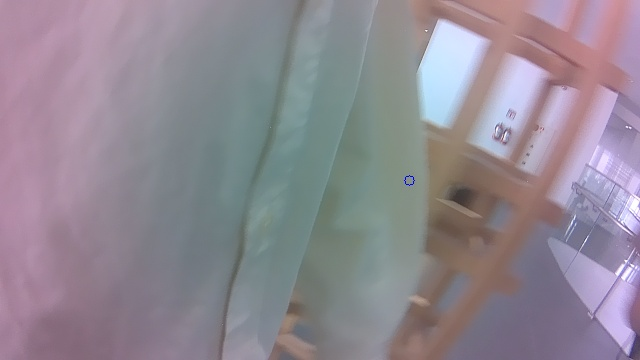

In [8]:
stream_and_process()